# Lab 4
### Contrast Enhancement

http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist



In [1]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.color import rgb2gray, rgb2hsv

# Convolution:
from scipy.signal import convolve2d
from scipy import fftpack
import math

from skimage.util import random_noise
from skimage.filters import median
from skimage.feature import canny

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# Edges
from skimage.filters import sobel_h, sobel, sobel_v, roberts, prewitt


In [2]:

# Show the figures / plots inside the notebook


def show_images(images, titles=None):
    # This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


def show_3d_image(img, title):
    fig = plt.figure()
    fig.set_size_inches((12, 8))
    ax = fig.gca(projection='3d')

    # Make data.
    X = np.arange(0, img.shape[0], 1)
    Y = np.arange(0, img.shape[1], 1)
    X, Y = np.meshgrid(X, Y)
    Z = img[X, Y]

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(0, 8)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_title(title)
    plt.show()


def show_3d_image_filtering_in_freq(img, f):
    img_in_freq = fftpack.fft2(img)
    filter_in_freq = fftpack.fft2(f, img.shape)
    filtered_img_in_freq = np.multiply(img_in_freq, filter_in_freq)

    img_in_freq = fftpack.fftshift(np.log(np.abs(img_in_freq)+1))
    filtered_img_in_freq = fftpack.fftshift(
        np.log(np.abs(filtered_img_in_freq)+1))

    show_3d_image(img_in_freq, 'Original Image')
    show_3d_image(filtered_img_in_freq, 'Filtered Image')


def showHist(img, bins=256):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=bins)

    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')


%matplotlib inline
%load_ext autoreload
%autoreload 2


In [3]:
'''
1
Negative Transformation
'''
def negative(img):
    new_img = np.zeros(img.shape)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            new_img[x][y] = 255 - img[x][y] 
    return new_img


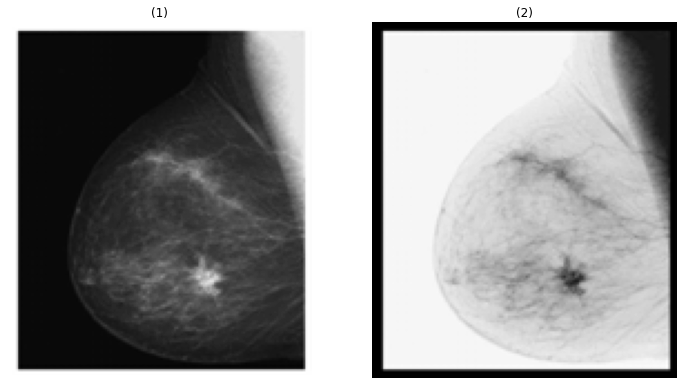

In [4]:
img=rgb2gray(io.imread('./imgs/Picture1.png')[:,:,:3])
show_images([img, negative(img)])

In [5]:
'''
2
Contrast Enhancement
'''
def contrast_enhancement(img):
    return np.where(img < 100, 50+img*150/100, img+100)


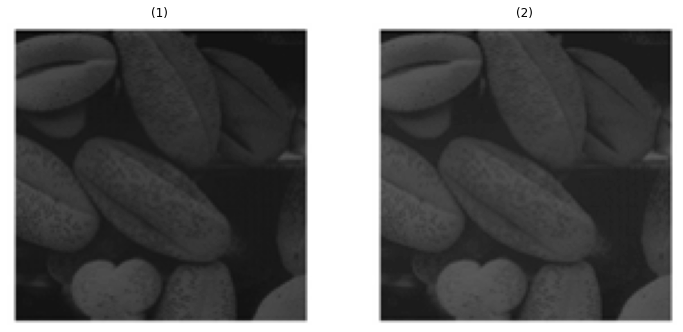

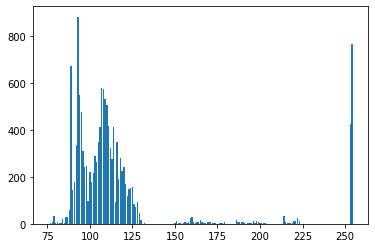

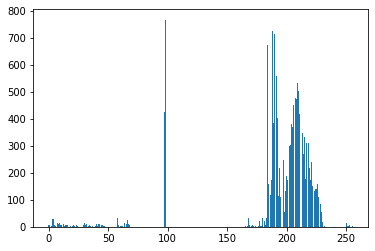

In [6]:
img = rgb2gray(io.imread('./imgs/Picture2.png')[:,:,:3]) * 255
show_images([img, contrast_enhancement(img)])
showHist(img)
showHist(contrast_enhancement(img))

In [7]:
'''
3
Gamma Correction
'''

def Gamma_Correction(img, c, gamma):
    new_img = img.copy()
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            new_img[x][y] = c * img[x][y] ** gamma
    return new_img

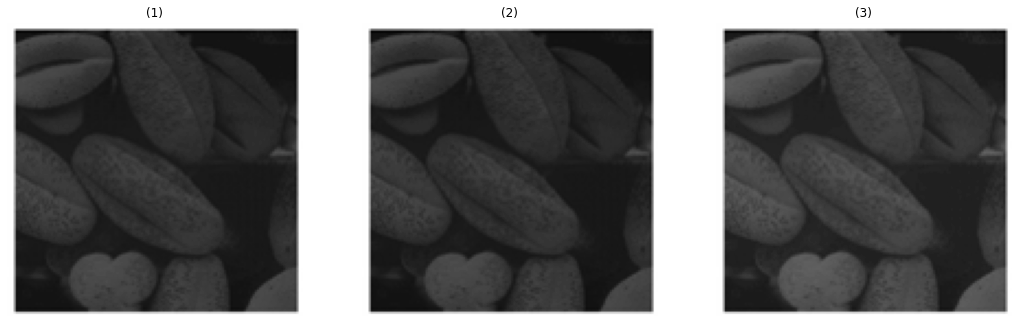

In [8]:
img = rgb2gray(io.imread('./imgs/Picture2.png')[:,:,:3]) * 255
show_images([img, Gamma_Correction(img, 1,1.05), Gamma_Correction(img, 1,0.5)])

In [9]:
'''
4 Histogram Eq.
Note: Histogram function of skimage returns only present intensity values not all 255
You can use showHist function from commonfunctions file
'''


def getImageWithHist(img, nbins=256):
    # histogram returns two arrays:
    # 0: array of counts
    # 1: array of values
    # Both arrays are of the same size and together they form histogram
    # Note: array sizes != nbins (zeros are removed from both ends but
    #       zeros in the middle aren't so that array 1 become incremental
    #       with contant step)
    # i.e. THERE IS A GAP IN THE START OF THE ARRAY
    # i.e. IT DOESN'T START FROM 0
    # 
    # Ex:
    # nbins = 10, pixels = 200
    # 0: 50, 0, 0, 30, 0, 40, 40, 0, 0, 40
    # 1: 6, 7, 8, 9, 10, 11, 12, 13, 14, 15
    # ARRAY_START = 6
    #
    #
    H = histogram(img, nbins)
    counts = H[0]
    values = H[1]
    ARRAY_START = values[0] # Because values array doesn't start from value 0
    MAX_COLOR_VALUE = 255
    TOTAL_COUNT = img.shape[0]*img.shape[1]
    # Step 1: Calculate cumulative counts from counts array and of same size
    Cumulative_Count = np.zeros(len(counts))
    Cumulative_Count[0] = counts[0]
    for i in range(1, len(counts)):
        Cumulative_Count[i] = Cumulative_Count[i-1] + counts[i]
    # Step 2: Calculate the new colors based on cumulative ratios (counts array / total count)
    new_img = np.zeros(img.shape)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            # New Color = Max new color value * Old color cumulative ratio
            # New Color = Max new color value * Old color cumulative count / Total count
            # Old color cumulative count =
            #           Cumulative count [ index of old color value in count array ]
            # Old color cumulative count =
            #           Cumulative count [ Old color value - Cumulative Count Start ]
            new_img[x][y] = round(MAX_COLOR_VALUE *
                                  Cumulative_Count[img[x][y] - ARRAY_START] /
                                  TOTAL_COUNT)
    # Show your results
    show_images([img])
    showHist(img, nbins)
    show_images([new_img])
    showHist(new_img, nbins)


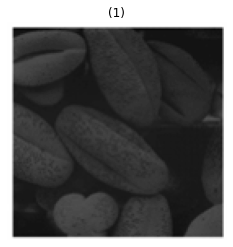

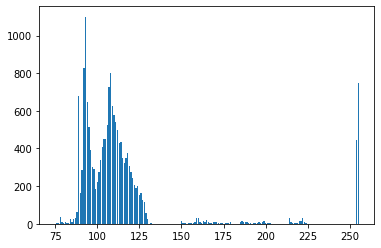

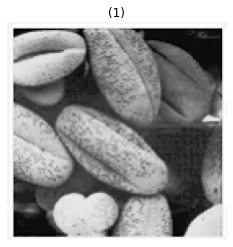

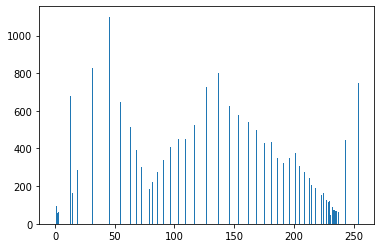

In [10]:
img = rgb2gray(io.imread('./imgs/Picture2.png')[:,:,:3]) * 255
getImageWithHist(img.astype('int'))

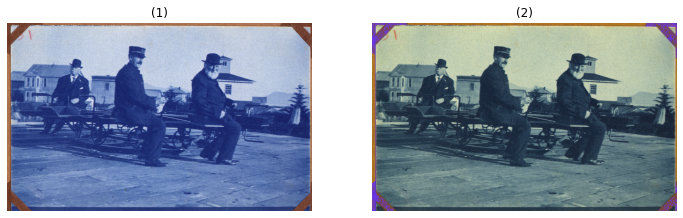

In [11]:
# Extra task
img1 = io.imread("./imgs/1.jpg")
new_img1 = img1.copy()
reduction_value = 50
for x in range(img1.shape[0]):
    for y in range(img1.shape[1]):
        new_img1[x][y][2] = img1[x][y][2]-reduction_value
show_images([img1,new_img1])

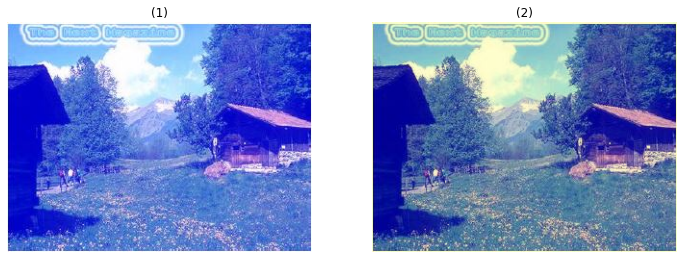

In [12]:
img1 = io.imread("./imgs/2.jpg")
new_img1 = img1.copy()
reduction_value = 50
for x in range(img1.shape[0]):
    for y in range(img1.shape[1]):
        new_img1[x][y][2] = img1[x][y][2]-reduction_value
show_images([img1,new_img1])